In [1]:
import numpy as np
import scipy.io as sio
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from keras.datasets import mnist

import matplotlib.pyplot as plt

import warnings
from datetime import datetime

import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler

import os
from tqdm import tqdm

# suppress warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Data

In [2]:
def lire_alpha_digit(chars):
    alpha_digits = sio.loadmat("data/binaryalphadigs.mat", squeeze_me=True)["dat"]

    arr = []
    y = []
    for i, char in enumerate(chars):
        if type(char) == int:
            char = str(char)

        asc_char = ord(char)
        if asc_char >= 65 and asc_char <= 90:
            for digit in alpha_digits[asc_char - 55]:
                arr.append(digit.flatten())
                y.append(asc_char - 55)
        elif asc_char >= 48 and asc_char <= 57:
            for digit in alpha_digits[asc_char - 48]:
                arr.append(digit.flatten())
                y.append(asc_char - 48)
        else:
            raise Exception("Char not valid")
    return np.array(arr), np.array(y)

def one_hot(y):
    unique_labels = np.unique(y)
    y_ohe = np.zeros((y.shape[0], len(unique_labels)))
    for i in range(y.shape[0]):
        y_ohe[i, np.where(unique_labels == y[i])] = 1
    return y_ohe

def lire_mnist(subsample_size=-1):
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # subsample
    if subsample_size != -1:
        X_train = X_train[:subsample_size]
        y_train = y_train[:subsample_size]

    # to binary and flatten
    X_train_bin = (X_train >= 128).astype(int).reshape(X_train.shape[0], -1)
    X_test_bin = (X_test >= 128).astype(int).reshape(X_test.shape[0], -1)

    # enc = OneHotEncoder(handle_unknown='ignore')
    # # enc.fit(y_train.reshape(-1, 1))
    # y_train = enc.fit_transform(y_train.reshape(-1, 1)).todense()
    # y_test = enc.fit_transform(y_test.reshape(-1, 1)).todense()
    y_train = one_hot(y_train)
    y_test = one_hot(y_test)

    return X_train_bin, X_test_bin, y_train, y_test

def char(idx):
    if 0 <= idx <= 9:
        return chr(idx + 48)
    else:
        return chr(idx + 55)

# Functions

In [3]:
def softmax(x):
    """
    Calcule la fonction softmax.
    """
    return (np.exp(x).T / np.sum(np.exp(x), axis=1)).T


def sigmoid(x):
    """
    Calcule la fonction sigmoïde.
    """
    return 1 / (1 + np.exp(-x))


def calcul_softmax(layer, X):
    """
    Calcule les probabilités sur les unités de sortie à partir de la fonction softmax. Cette fonction retournera les probabilités sur les unités de sortie et prendra en argument un RBM et des données d'entrée.
    """
    return softmax(np.dot(X, layer.W) + layer.b)

def err_rate(acc_list):
    """ Calcule une liste de taux d'erreur avec la liste d'accuracy score en entrée """
    return [1-acc for acc in acc_list]

# Plot functions
and save png

In [4]:
# Create directory to save plots
savepath = 'save/'
if not os.path.exists(savepath):
    os.makedirs(savepath)
    print('Directory "' + str(savepath) + '" created')

def plot_data(X, y=None, save=False):
    perm = np.random.permutation(X.shape[0])
    plt.figure()
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[perm[i]], cmap="gray")
        if y is not None:
            plt.xlabel(char(y[perm[i]]))
    plt.tight_layout()
    if save:
        plt.savefig(f"{savepath + save}.png")
    plt.show()


def plot_batched_images(batched_images, variables, save=False):
    plt.figure(figsize=(4 * 1.5, len(variables) * 1.5))
    for i, images in enumerate(batched_images):
        for j, img in enumerate(images):
            plt.subplot(len(images), len(batched_images), i + 1 + j * len(variables))
            plt.imshow(img, cmap="gray")
            if j == 0:
                plt.title(f"{variables[i]}")
            plt.axis("off")
    plt.tight_layout()
    if save:
        plt.savefig(f"{savepath + save}.png")
    plt.show()


def plot_preds(X, y_true, y_pred, save=False):
    num_cols = 3
    num_rows = 3

    # random permutation on test set
    perm = np.random.permutation(len(y_true))

    plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
    for i in range(num_rows * num_cols):
        idx = perm[i]
        true_label = np.argmax(y_true[idx])
        predictions_array = y_pred[idx]
        predicted_label = np.argmax(predictions_array)

        if true_label == predicted_label:
            color = "blue"
        else:
            color = "red"

        # image
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(X[idx].reshape(28, 28), cmap=plt.cm.gray)
        plt.xlabel(
            "truth={}, pred={}, score={:2.0f}".format(
                true_label,
                predicted_label,
                100 * np.max(predictions_array),
                color=color,
            )
        )

        # probs
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        bp = plt.bar(range(10), predictions_array, color="#777777")
        bp[predicted_label].set_color("red")
        bp[true_label].set_color("blue")
        plt.ylim([0, 1])

    if save:
        plt.savefig(f"{savepath + save}.png")

    plt.show()

def plot_DNN(x_axis, acc_1, acc_2, acc_1_train=None, acc_2_train=None, y_label='', save=False):
    """ Plot DNN résultats paramètres """
    plt.plot(
        x_axis,
        err_rate(acc_1),
        label="Pretrain + train (test set)",
        color='blue',
        marker="o",
        markersize=8,
    )
    if acc_1_train != None:
        plt.plot(
            x_axis,
            err_rate(acc_1_train),
            label="Pretrain + train (train set)",
            color='blue',
            linestyle='dashed', 
            linewidth=.5
        )
    plt.plot(
        x_axis,
        err_rate(acc_2),
        label="Train only (test set)",
        color='orange',
        marker="o",
        markersize=8
    )
    if acc_2_train != None:
        plt.plot(
            x_axis,
            err_rate(acc_2_train),
            label="Train only (train set)",
            color='orange',
            linestyle='dashed',
            linewidth=.5    
        )
    plt.xticks(x_axis)
    plt.xlabel(y_label)
    plt.ylabel("Error rate")
    plt.legend()
    if save:
        plt.savefig(savepath + save + ".png")
    plt.show()

# RBM

In [5]:
class RBM:
    def __init__(self, p, q):
        self.W = np.random.normal(0, 0.01, (p, q))
        self.a = np.zeros(p)
        self.b = np.zeros(q)


def init_RBM(p, q):
    """
    Construit et initialise les poids et les biais d'un RBM. Cette fonction retournera une structure RBM avec des poids et biais initialisés.
    On initialisera les biais à 0 tandis que les poids seront initialisés aléatoirement suivant une loi normale centrée, de variance égale à 0.01.
    """
    rbm = RBM(p, q)
    return rbm


def entree_sortie_RBM(rbm, X):
    """
    Calcule la valeur des unités de sortie d'un RBM à partir des données d'entrée et de la fonction sigmoïde.
    """
    return sigmoid(np.dot(X, rbm.W) + rbm.b)


def sortie_entree_RBM(rbm, H):
    """
    Calcule la valeur des unités d'entrée d'un RBM à partir des données de sortie et de la fonction sigmoïde.
    """
    return sigmoid(np.dot(H, rbm.W.T) + rbm.a)


def train_RBM(rbm, X, epochs, lr, batch_size):
    """
    Apprend un RBM par l'algorithme Contrastive-Divergence-1. Cette fonction retournera un structure
    RBM et prendra en argument une structure RBM, le nombre d'itérations de la descente de gradient (epochs),
    le learning rate, la taille du mini-batch, des données d'entrées...
    """
    print("Training RBM...")
    n = X.shape[0]
    p, q = rbm.W.shape
    for epoch in tqdm(range(epochs)):
        X_copy = np.copy(X)
        np.random.shuffle(X_copy)
        for i in range(0, n, batch_size):
            v_0 = X[i : i + batch_size]
            tb = len(v_0)
            es_v_0 = entree_sortie_RBM(rbm, v_0)
            h_0 = (np.random.uniform(size=(tb, q)) < es_v_0).astype("float")
            v_1 = (
                np.random.uniform(size=(tb, p)) < sortie_entree_RBM(rbm, h_0)
            ).astype("float")
            h_1 = entree_sortie_RBM(rbm, v_1)
            rbm.W += lr / tb * (np.dot(v_0.T, es_v_0) - np.dot(v_1.T, h_1))
            rbm.a += lr / tb * np.sum(v_0 - v_1, axis=0)
            rbm.b += lr / tb * np.sum(es_v_0 - h_1, axis=0)
    return rbm


def generer_image_RBM(rbm, n_iter, n_image):
    """
    Génère des échantillons suivant un RBM. Cette fonction retournera et affichera les images générées et prendra en argument une structure de type RBM, le nombre d'itérations à utiliser dans l'échantillonneur de Gibbs et le nombre d'images à générer.
    """
    p, q = rbm.W.shape
    X = (np.random.uniform(size=(n_image, p)) < 0.5).astype("float")
    for i in range(n_iter):
        H = (np.random.uniform(size=(n_image, q)) < entree_sortie_RBM(rbm, X)).astype(
            "float"
        )
        X = (np.random.uniform(size=(n_image, p)) < sortie_entree_RBM(rbm, H)).astype(
            "float"
        )
    return X

# DBN

In [6]:
class DBN:
    def __init__(self, n_layers):
        self.layers = []
        for i in range(len(n_layers) - 1):
            self.layers.append(RBM(n_layers[i], n_layers[i + 1]))

    def __len__(self):
        return len(self.layers)

    def __getitem__(self, i):
        return self.layers[i]

    def __setitem__(self, i, layer):
        self.layers[i] = layer


def init_DBN(n_layers):
    """
    Construit et initialise les poids et les biais d'un DBN. Cette fonction retournera un DBN avec des poids et biais initialisés.
    On initialisera les biais à 0 tandis que les poids seront initialisés aléatoirement suivant une loi normale centrée, de variance égale à 0.01.
    """
    dbn = DBN(n_layers)
    return dbn


def train_DBN(dbn, X_init, epochs, lr, batch_size):
    """
    Apprend un DBN par la méthode Greedy Layer-Wise. Cette fonction retournera un DBN pré-entrainé et prendra en argument un DBN, le nombre d'itérations de la descente de gradient, le learning rate, la taille du mini-batch, des données d'entrées.
    """
    print("Training DBN...")
    X = X_init
    for rbm in dbn:
        rbm = train_RBM(rbm, X, epochs, lr, batch_size)
        X = entree_sortie_RBM(rbm, X)
    return dbn


def generer_image_DBN(dbn, n_iter, n_image):
    """
    Génère des échantillons suivant un DBN. Cette fonction retournera et affichera les images générées et prendra en argument un DBN pré-entrainé, le nombre d'itérations à utiliser dans l'échantillonneur de Gibbs et le nombre d'images à générer.
    """
    X = generer_image_RBM(dbn[-1], n_iter, n_image)
    for i in range(len(dbn) - 2, -1, -1):
        p, q = dbn[i].W.shape
        X = (
            np.random.uniform(size=(n_image, p)) < sortie_entree_RBM(dbn[i], X)
        ).astype("float")
    return X

# DNN

In [7]:
class FC:
    def __init__(self, p, q):
        self.W = np.random.normal(0, 0.1, (p, q))
        self.b = np.zeros(q)


class DNN(DBN):
    def __init__(self, n_layers):
        self.layers = []
        for i in range(len(n_layers) - 2):
            self.layers.append(RBM(n_layers[i], n_layers[i + 1]))
        self.layers.append(FC(n_layers[-2], n_layers[-1]))


def init_DNN(n_layers):
    """
    Construit et initialise les poids et les biais d'un DNN. Cette fonction retournera un DNN avec des poids et biais initialisés.
    On initialisera les biais à 0 tandis que les poids seront initialisés aléatoirement suivant une loi normale centrée, de variance égale à 0.01.
    """
    dnn = DNN(n_layers)
    return dnn


def pretrain_DNN(dnn, X_init, epochs, lr, batch_size):
    """
    Pré-entraine un DNN. Cette fonction retournera un DNN pré-entrainé et prendra en argument un DNN, le nombre d'itérations de la descente de gradient, le learning rate, la taille du mini-batch, des données d'entrées.
    """
    print("Pretraining DNN...")
    X = X_init
    for rbm in dnn[:-1]:
        rbm = train_RBM(rbm, X, epochs, lr, batch_size)
        X = entree_sortie_RBM(rbm, X)
    return dnn


def entree_sortie_reseau(dnn, X):
    """
    Calcule les sorties sur chaque couche du réseau (couche d'entrée inclue) ainsi que les probabilités sur les unités de sortie. Cette fonction retournera une liste contenant les sorties sur chaque couche du réseau ainsi que les probabilités sur les unités de sortie et prendra en argument un DNN et des données d'entrée.
    """
    sorties = [X]
    for rbm in dnn[:-1]:
        sorties.append(entree_sortie_RBM(rbm, sorties[-1]))
    sorties.append(calcul_softmax(dnn[-1], sorties[-1]))
    return sorties


def retropropagation(dnn, X, y, epochs, lr, batch_size, verbose):
    """
    Estime les poids/biais du réseau à partir de données labellisées. Cette fonction retournera un DNN et prendra en argument un DNN, le nombre d'itérations de la descente de gradient, le learning rate, la taille du mini-batch, des données d'entrée, leur label,...
    """
    print("Training DNN...")
    for epoch in tqdm(range(epochs)):
        for i in range(0, X.shape[0], batch_size):
            X_batch = X[i : i + batch_size]
            y_batch = y[i : i + batch_size]
            tb = len(X_batch)
            sortie = entree_sortie_reseau(
                dnn,
                X_batch,
            )
            # compute dL/dZ
            d_Z = sortie[-1] - y_batch

            for j in range(len(dnn) - 1, -1, -1):
                grad_W = 1 / tb * np.dot(sortie[j].T, d_Z)
                grad_b = 1 / tb * np.sum(d_Z, axis=0)

                # update W and b
                dnn.layers[j].W -= lr * grad_W
                dnn.layers[j].b -= lr * grad_b

                if j == 0:  # no need to compute at last iteration
                    break

                # compute dL/dA and dL/dZ
                d_A = np.dot(d_Z, dnn[j].W.T)
                d_Z = d_A * sortie[j] * (1 - sortie[j])
            cross_entropy = -np.mean(np.sum(y_batch * np.log(sortie[-1]), axis=1))
        if verbose == 2:
            print(f"Epoch {epoch} - CE:", cross_entropy)
    return dnn


def test_DNN(dnn, X, y):
    """
    Teste les performances du réseau appris. Cette fonction retournera le taux d'erreur et prendra en argument un DNN appris, un jeu de données test, et les vrais labels associés.
    """
    sortie = entree_sortie_reseau(dnn, X)
    # Compute cross entropy
    cross_entropy = -np.mean(np.sum(y * np.log(sortie[-1]), axis=1))
    return sortie[-1], cross_entropy

# Run

In [8]:
def RBM_main(
    X,
    width: int,
    height: int,
    q: int,
    epochs: int,
    lr,
    batch_size: int,
    n_images: int = 9,
):

    rbm = init_RBM(p=width * height, q=q)
    
    train_RBM(rbm, X, epochs, lr, batch_size)

    X_gen = generer_image_RBM(rbm, 100, n_images).reshape(-1, width, height)
    return X_gen

In [9]:
def DBN_main(
    X,
    n_layers,
    width: int,
    height: int,
    epochs: int,
    lr,
    batch_size: int,
    n_images: int = 9,
):
    dbn = init_DBN(n_layers)

    train_DBN(dbn, X, epochs, lr, batch_size)

    X_gen = generer_image_DBN(dbn, 100, n_images).reshape(-1, width, height)
    return X_gen

In [10]:
def DNN_main(
    X_train,
    X_test,
    y_train,
    y_test,
    n_layers,
    lr,
    batch_size,
    pretrain_iter,
    train_iter,
    show_preds=False,
    verbose=1,
):
    # Initialisation du DNN
    dnn = init_DNN(n_layers)

    # Pré-entrainement du DNN
    
    if pretrain_iter:
        print('pré-entrainement')
        dnn = pretrain_DNN(dnn, X_train, pretrain_iter, lr, batch_size)

    # Entrainement du DNN
    print('entrainement')
    dnn = retropropagation(
        dnn, X_train, y_train, train_iter, lr, batch_size, verbose
    )

    # Test du DNN
    print('train')
    y_train_pred, cross_entropy_train = test_DNN(dnn, X_train, y_train)
    train_score = accuracy_score(
        np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1)
    )
    # Test du DNN
    print('test')
    y_pred, cross_entropy = test_DNN(dnn, X_test, y_test)
    test_score = accuracy_score(
        np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)
    )

    if verbose >= 1:
        print("accuracy_score (train)", train_score)
        print("accuracy_score (test)", test_score)

    if show_preds:
        plot_preds(X_test, y_test, y_pred, save="mnist_preds_with_prob")

    return cross_entropy, test_score, train_score

# Etude sur Binary AlphaDigit

In [11]:
alphadigit = [str(i) for i in range(10)] + [chr(i) for i in range(65, 91)]

X, y = lire_alpha_digit(chars=alphadigit)
height = 20
width = 16

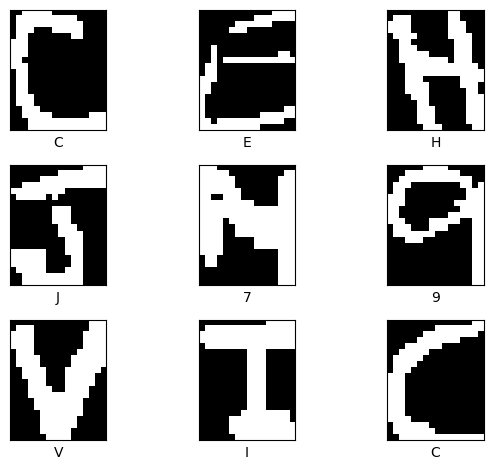

In [12]:
plot_data(X.reshape(-1, height, width), y, save="binary_alphadigit")

# Nombre de neurones

In [13]:
digit = [str(i) for i in range(2, 10)]
X, y = lire_alpha_digit(chars=digit)

n_neurons = range(100, 701, 200)

epochs = 100
lr = 0.1
batch_size = 10

rbm_images = []
dbn_images = []

for n in n_neurons:
    print(f"--- {n} neurons by layer ---")

    X_gen_rbm = RBM_main(
        X,
        height,
        width,
        n,
        epochs,
        lr,
        batch_size,
    )

    idxs = np.random.choice(X_gen_rbm.shape[0], 4, replace=False)
    rbm_images.append(X_gen_rbm[idxs])

    X_gen_dbn = DBN_main(
        X,
        [320, n, n],
        height,
        width,
        epochs,
        lr,
        batch_size,
    )

    idxs = np.random.choice(X_gen_dbn.shape[0], 4, replace=False)
    dbn_images.append(X_gen_dbn[idxs])

--- 100 neurons by layer ---
Training RBM...


100%|██████████| 100/100 [00:02<00:00, 43.98it/s]


Training DBN...
Training RBM...


100%|██████████| 100/100 [00:02<00:00, 45.12it/s]


Training RBM...


100%|██████████| 100/100 [00:00<00:00, 250.88it/s]


--- 300 neurons by layer ---
Training RBM...


100%|██████████| 100/100 [00:03<00:00, 26.31it/s]


Training DBN...
Training RBM...


100%|██████████| 100/100 [00:03<00:00, 26.23it/s]


Training RBM...


100%|██████████| 100/100 [00:03<00:00, 26.95it/s]


--- 500 neurons by layer ---
Training RBM...


100%|██████████| 100/100 [00:06<00:00, 14.35it/s]


Training DBN...
Training RBM...


100%|██████████| 100/100 [00:09<00:00, 11.06it/s]


Training RBM...


100%|██████████| 100/100 [00:12<00:00,  7.81it/s]


--- 700 neurons by layer ---
Training RBM...


100%|██████████| 100/100 [00:10<00:00,  9.36it/s]


Training DBN...
Training RBM...


100%|██████████| 100/100 [00:10<00:00,  9.33it/s]


Training RBM...


100%|██████████| 100/100 [00:21<00:00,  4.67it/s]


RBM


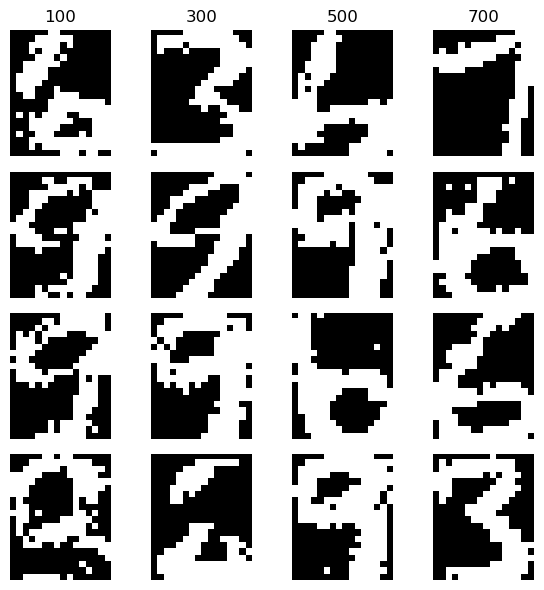

DBN


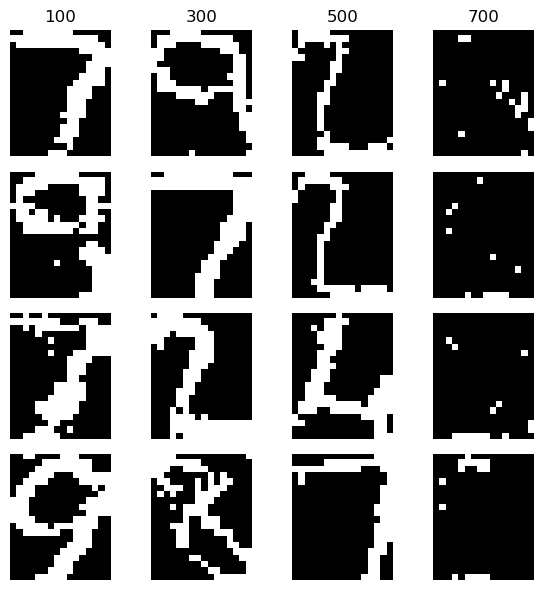

In [14]:
print("RBM")
plot_batched_images(rbm_images, n_neurons, save="rbm_n_neurons")

print("DBN")
plot_batched_images(dbn_images, n_neurons, save="dbn_n_neurons")

# Nombre de couches

In [15]:
digit = [str(i) for i in range(2, 10)]
X, y = lire_alpha_digit(chars=digit)

n_layers = range(2, 6)

epochs = 100
lr = 0.1
batch_size = 10
q = 200

dbn_images = []

for n in n_layers:
    print(f"--- {n} layers ---")
    layers = [200] * n

    X_gen_dbn = DBN_main(
        X,
        [320] + layers,
        height,
        width,
        epochs,
        lr,
        batch_size,
    )

    idxs = np.random.choice(X_gen_dbn.shape[0], 4, replace=False)
    dbn_images.append(X_gen_dbn[idxs])

--- 2 layers ---
Training DBN...
Training RBM...


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:03<00:00, 29.56it/s]


Training RBM...


100%|██████████| 100/100 [00:02<00:00, 33.77it/s]


--- 3 layers ---
Training DBN...
Training RBM...


100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Training RBM...


100%|██████████| 100/100 [00:02<00:00, 49.67it/s]


Training RBM...


100%|██████████| 100/100 [00:02<00:00, 48.05it/s]


--- 4 layers ---
Training DBN...
Training RBM...


100%|██████████| 100/100 [00:02<00:00, 36.92it/s]


Training RBM...


100%|██████████| 100/100 [00:01<00:00, 52.90it/s]


Training RBM...


100%|██████████| 100/100 [00:02<00:00, 42.69it/s]


Training RBM...


100%|██████████| 100/100 [00:02<00:00, 37.24it/s]


--- 5 layers ---
Training DBN...
Training RBM...


100%|██████████| 100/100 [00:02<00:00, 37.85it/s]


Training RBM...


100%|██████████| 100/100 [00:02<00:00, 49.82it/s]


Training RBM...


100%|██████████| 100/100 [00:01<00:00, 50.46it/s]


Training RBM...


100%|██████████| 100/100 [00:02<00:00, 44.37it/s]


Training RBM...


100%|██████████| 100/100 [00:04<00:00, 23.95it/s]


DBN


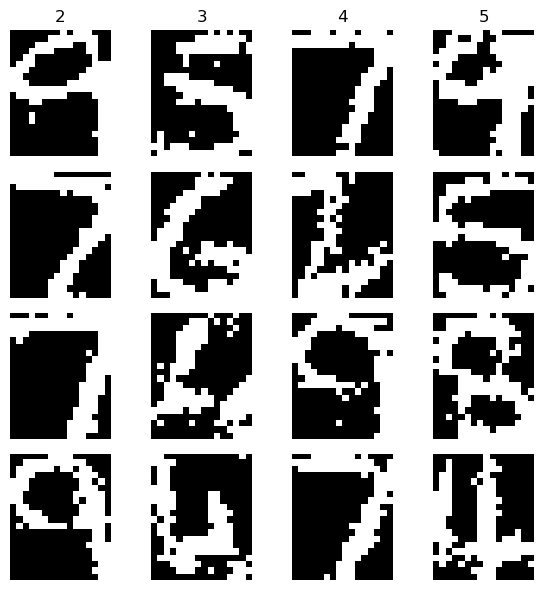

In [16]:
print("DBN")
plot_batched_images(dbn_images, n_layers, save="dbn_n_layers")

# Nombre de caractères

In [17]:
small = ["2", "3", "4"]
medium = [str(i) for i in range(2, 10)]
large = [chr(i) for i in range(65, 91)]

print("Small:", small)
print("Medium:", medium)
print("Large:", large)

Small: ['2', '3', '4']
Medium: ['2', '3', '4', '5', '6', '7', '8', '9']
Large: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [18]:
epochs = 100
lr = 0.1
batch_size = 10
q = 200
n_layers = [320, 200, 200]

rbm_images = []
dbn_images = []

for size, chars in zip(["small", "medium", "large"], [small, medium, large]):
    print("--- Size:", size, "---")
    X, y = lire_alpha_digit(chars=chars)

    X_gen_rbm = RBM_main(
        X,
        height,
        width,
        q,
        epochs,
        lr,
        batch_size,
    )

    idxs = np.random.choice(X_gen_rbm.shape[0], 4, replace=False)
    rbm_images.append(X_gen_rbm[idxs])

    X_gen_dbn = DBN_main(
        X,
        n_layers,
        height,
        width,
        epochs,
        lr,
        batch_size,
    )

    idxs = np.random.choice(X_gen_dbn.shape[0], 4, replace=False)
    dbn_images.append(X_gen_dbn[idxs])

--- Size: small ---
Training RBM...


100%|██████████| 100/100 [00:01<00:00, 66.92it/s]


Training DBN...
Training RBM...


100%|██████████| 100/100 [00:01<00:00, 84.81it/s]


Training RBM...


100%|██████████| 100/100 [00:00<00:00, 116.20it/s]


--- Size: medium ---
Training RBM...


100%|██████████| 100/100 [00:03<00:00, 32.54it/s]


Training DBN...
Training RBM...


100%|██████████| 100/100 [00:03<00:00, 32.73it/s]


Training RBM...


100%|██████████| 100/100 [00:02<00:00, 41.70it/s]


--- Size: large ---
Training RBM...


100%|██████████| 100/100 [00:09<00:00, 10.89it/s]


Training DBN...
Training RBM...


100%|██████████| 100/100 [00:10<00:00,  9.57it/s]


Training RBM...


100%|██████████| 100/100 [00:07<00:00, 13.05it/s]


RBM


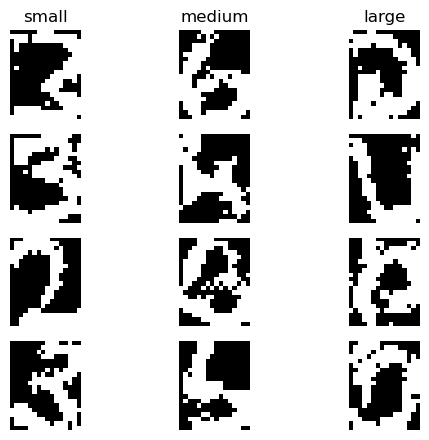

DBN


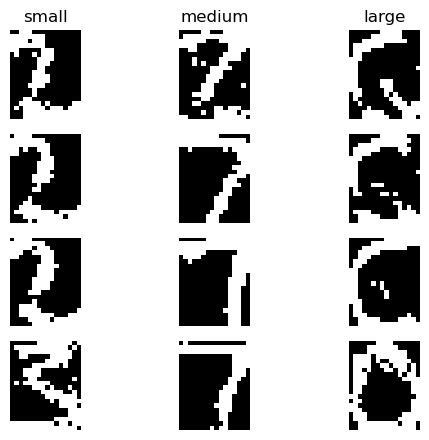

In [19]:
print("RBM")
plot_batched_images(rbm_images, ["small", "medium", "large"], save="rbm_dataset_size")

print("DBN")
plot_batched_images(dbn_images, ["small", "medium", "large"], save="dbn_dataset_size")

# Etude sur MNIST

In [40]:
#----------
train_size = 12000 # Default = 30000
n_main = 10 # standard number of neurons per layer (default = 100)
n_hidden = 2 # default = 2
pretrain_iter = 20 # 100 default = 50?
train_iter = 100 # 200 default = 200?

# Create directory to save plots
savepath = 'save' + '_' + str(train_size) + '_' + str(n_main) + '_' + str(n_hidden) + '_' + str(pretrain_iter) +'_' + str(train_iter) + '/'
if not os.path.exists(savepath):
    os.makedirs(savepath)
    print('Directory "' + str(savepath) + '" created')
#----------

X_train, X_test, y_train, y_test = lire_mnist(subsample_size=train_size) # -1

batch_size = 256 # 2000 
lr = 0.1

n_layers = [784] + [n_main] * n_hidden + [10]


Directory "save_12000_10_2_20_100/" created


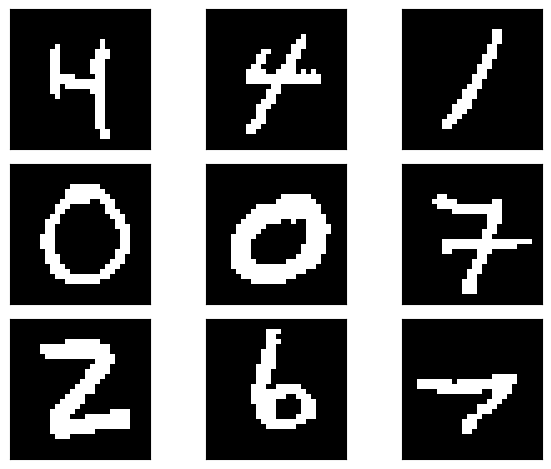

In [41]:
plot_data(X_train.reshape(-1, 28, 28), save="mnist")

entrainement
Training DNN...


100%|██████████| 100/100 [00:07<00:00, 14.02it/s]


train
test
accuracy_score (train) 0.9293333333333333
accuracy_score (test) 0.8954


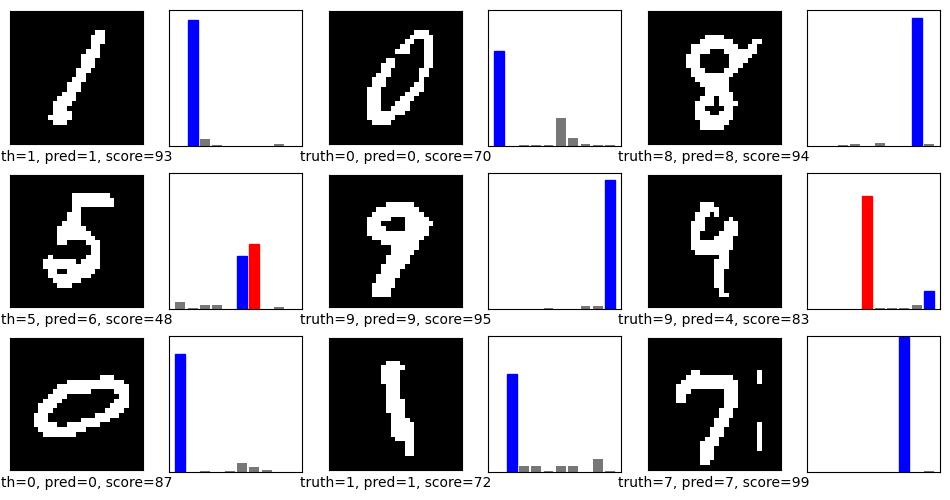

In [42]:
ce, score, train_score = DNN_main(
    X_train,
    X_test,
    y_train,
    y_test,
    n_layers=[784, n_main, 10], #--------
    lr=lr,
    batch_size=batch_size,
    pretrain_iter=None,
    train_iter=train_iter,
    show_preds=True,
    verbose=True,
)

#### Fig 1 : 2 courbes exprimant le taux d’erreur des 2 réseaux en fonction du nombre de couches (par exemple 2 couches de 200, puis 3 couches de 200, ... puis 5 couches de 200). On utilisera toutes les données d’apprentissage et test;

In [43]:
acc_1_layer = []
acc_2_layer = []
acc_1_train_layer = []
acc_2_train_layer = []

sizes = range(1, 6)

for size in sizes:
    print(f"--- {size} hidden layer(s) ---")
    n_layers = [784] + [n_main] * size + [10]  #--------
    """-------------- Model 1 : pre-train + train -------------------"""
    ce_model1, score_model1, train_score_model1 = DNN_main(
        X_train,
        X_test,
        y_train,
        y_test,
        n_layers=n_layers,
        lr=lr,
        batch_size=batch_size,
        pretrain_iter=pretrain_iter,
        train_iter=train_iter,
        verbose=1,
    )
    acc_1_layer.append(score_model1)
    acc_1_train_layer.append(train_score_model1)

    """-------------- Model 2 : train only ---------------------------"""
    ce_model2, score_model2, train_score_model2  = DNN_main(
        X_train,
        X_test,
        y_train,
        y_test,
        n_layers=n_layers,
        lr=lr,
        batch_size=batch_size,
        pretrain_iter=False,
        train_iter=train_iter,
        verbose=1,
    )
    acc_2_layer.append(score_model2)
    acc_2_train_layer.append(train_score_model2)

--- 1 hidden layer(s) ---
pré-entrainement
Pretraining DNN...
Training RBM...


100%|██████████| 20/20 [00:08<00:00,  2.23it/s]


entrainement
Training DNN...


100%|██████████| 100/100 [00:05<00:00, 18.39it/s]


train
test
accuracy_score (train) 0.7625833333333333
accuracy_score (test) 0.7465
entrainement
Training DNN...


100%|██████████| 100/100 [00:05<00:00, 16.97it/s]


train
test
accuracy_score (train) 0.9315
accuracy_score (test) 0.8984
--- 2 hidden layer(s) ---
pré-entrainement
Pretraining DNN...
Training RBM...


100%|██████████| 20/20 [00:06<00:00,  3.32it/s]


Training RBM...


100%|██████████| 20/20 [00:00<00:00, 61.33it/s]


entrainement
Training DNN...


100%|██████████| 100/100 [00:06<00:00, 16.38it/s]


train
test
accuracy_score (train) 0.68275
accuracy_score (test) 0.6622
entrainement
Training DNN...


100%|██████████| 100/100 [00:06<00:00, 16.01it/s]


train
test
accuracy_score (train) 0.6291666666666667
accuracy_score (test) 0.6204
--- 3 hidden layer(s) ---
pré-entrainement
Pretraining DNN...
Training RBM...


100%|██████████| 20/20 [00:07<00:00,  2.84it/s]


Training RBM...


100%|██████████| 20/20 [00:00<00:00, 61.46it/s]


Training RBM...


100%|██████████| 20/20 [00:00<00:00, 53.03it/s]


entrainement
Training DNN...


100%|██████████| 100/100 [00:10<00:00,  9.41it/s]


train
test
accuracy_score (train) 0.11258333333333333
accuracy_score (test) 0.1135
entrainement
Training DNN...


100%|██████████| 100/100 [00:06<00:00, 15.35it/s]


train
test
accuracy_score (train) 0.11258333333333333
accuracy_score (test) 0.1135
--- 4 hidden layer(s) ---
pré-entrainement
Pretraining DNN...
Training RBM...


100%|██████████| 20/20 [00:07<00:00,  2.73it/s]


Training RBM...


100%|██████████| 20/20 [00:00<00:00, 61.07it/s]


Training RBM...


100%|██████████| 20/20 [00:00<00:00, 57.18it/s]


Training RBM...


100%|██████████| 20/20 [00:00<00:00, 64.61it/s]


entrainement
Training DNN...


100%|██████████| 100/100 [00:11<00:00,  9.09it/s]


train
test
accuracy_score (train) 0.11258333333333333
accuracy_score (test) 0.1135
entrainement
Training DNN...


100%|██████████| 100/100 [00:08<00:00, 12.37it/s]


train
test
accuracy_score (train) 0.11258333333333333
accuracy_score (test) 0.1135
--- 5 hidden layer(s) ---
pré-entrainement
Pretraining DNN...
Training RBM...


100%|██████████| 20/20 [00:10<00:00,  2.00it/s]


Training RBM...


100%|██████████| 20/20 [00:00<00:00, 60.72it/s]


Training RBM...


100%|██████████| 20/20 [00:00<00:00, 63.08it/s]


Training RBM...


100%|██████████| 20/20 [00:00<00:00, 60.79it/s]


Training RBM...


100%|██████████| 20/20 [00:00<00:00, 63.78it/s]


entrainement
Training DNN...


100%|██████████| 100/100 [00:08<00:00, 11.60it/s]


train
test
accuracy_score (train) 0.11258333333333333
accuracy_score (test) 0.1135
entrainement
Training DNN...


100%|██████████| 100/100 [00:09<00:00, 10.45it/s]


train
test
accuracy_score (train) 0.11258333333333333
accuracy_score (test) 0.1135


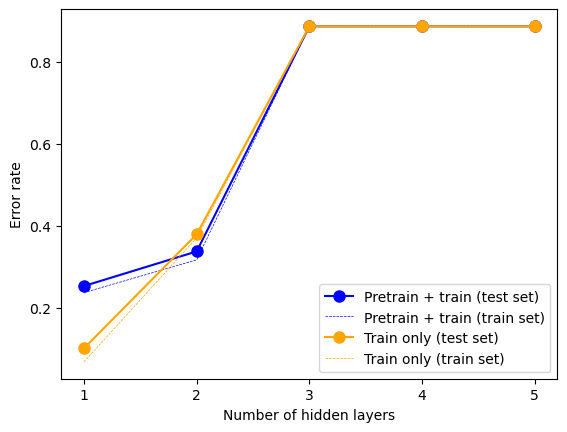

In [44]:
plot_DNN(
    sizes, 
    acc_1_layer, 
    acc_2_layer, 
    acc_1_train=acc_1_train_layer, 
    acc_2_train=acc_2_train_layer, 
    y_label='Number of hidden layers', 
    save="mnist_number_hidden_layers"
    )

#### Fig 2 : 2 courbes exprimant le taux d’erreur des 2 réseaux en fonction du nombre de neurones par couches (par exemple 2 couches de 100, puis 2 couches de 300, ...puis 2 couches de 700,...). on utilisera toutes les données d’apprentissage et test;

In [45]:
acc_1_neurons = []
acc_2_neurons = []
acc_1_train_neurons = []
acc_2_train_neurons = []

start = 1
stop = 11
step = 4 # reduce: 2 ---------------------------------------------------------------
n_neurons = range(start * n_main, stop * n_main + 1, step * n_main)


for neurons in n_neurons:
    print(f"--- {neurons} neurons by layer, {n_hidden} layers ---")
    n_layers = [784] + [neurons] * n_hidden +  [10]
    """-------------- Model 1 : pre-train + train -------------------"""
    ce_model1, score_model1, train_score_model1 = DNN_main(
        X_train,
        X_test,
        y_train,
        y_test,
        n_layers=n_layers,
        lr=lr,
        batch_size=batch_size,
        pretrain_iter=pretrain_iter,
        train_iter=train_iter,
        verbose=1,
    )
    acc_1_neurons.append(score_model1)
    acc_1_train_neurons.append(train_score_model1)

    """-------------- Model 2 : train only ---------------------------"""
    ce_model2, score_model2, train_score_model2 = DNN_main(
        X_train,
        X_test,
        y_train,
        y_test,
        n_layers=n_layers,
        lr=lr,
        batch_size=batch_size,
        pretrain_iter=False,
        train_iter=train_iter,
        verbose=1,
    )
    acc_2_neurons.append(score_model2)
    acc_2_train_neurons.append(train_score_model2)

--- 10 neurons by layer, 2 layers ---
pré-entrainement
Pretraining DNN...
Training RBM...


100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


Training RBM...


100%|██████████| 20/20 [00:00<00:00, 63.54it/s]


entrainement
Training DNN...


100%|██████████| 100/100 [00:08<00:00, 11.89it/s]


train
test
accuracy_score (train) 0.5758333333333333
accuracy_score (test) 0.5491
entrainement
Training DNN...


100%|██████████| 100/100 [00:07<00:00, 13.94it/s]


train
test
accuracy_score (train) 0.624
accuracy_score (test) 0.6054
--- 50 neurons by layer, 2 layers ---
pré-entrainement
Pretraining DNN...
Training RBM...


100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


Training RBM...


100%|██████████| 20/20 [00:01<00:00, 10.21it/s]


entrainement
Training DNN...


100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


train
test
accuracy_score (train) 0.9164166666666667
accuracy_score (test) 0.9009
entrainement
Training DNN...


100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


train
test
accuracy_score (train) 0.9033333333333333
accuracy_score (test) 0.8838
--- 90 neurons by layer, 2 layers ---
pré-entrainement
Pretraining DNN...
Training RBM...


 70%|███████   | 14/20 [00:08<00:03,  1.58it/s]

In [ ]:
len(acc_1_neurons), len(acc_2_neurons), len(acc_1_train_neurons), len(acc_2_train_neurons)

(3, 3, 3, 3)

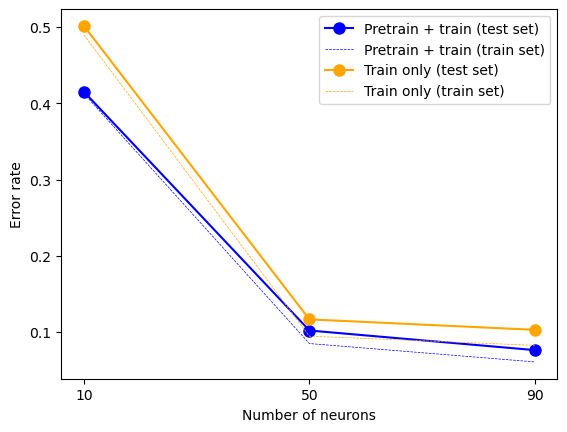

In [ ]:
plot_DNN(
    n_neurons, 
    acc_1_neurons, 
    acc_2_neurons, 
    acc_1_train=acc_1_train_neurons, 
    acc_2_train=acc_2_train_neurons, 
    y_label='Number of neurons', 
    save="mnist_number_of_neurons"
    )

#### Fig 3 : 2 courbes exprimant le taux d’erreur des 2 réseaux en fonction du nombre de données train (par exemple on fixe 2 couches de 200 puis on utilise 1000 données train, 3000, 7000, 10000, 30000, 60000).

In [ ]:
acc_1_train_size = []
acc_2_train_size = []
acc_1_train_size_train = []
acc_2_train_size_train = []

n_layers = [784] + [2 * n_main] * n_hidden +  [10]

samples_sizes = [2000, 6000, 12000, 30000] # ------------------------------------------
# samples_sizes = [1000, 2000, 3000, 60000, 12000, 30000, 60000]

for size in samples_sizes:
    print(f"--- {size} samples ---")
    X_train_, X_test_, y_train_, y_test_ = lire_mnist(subsample_size=size)

    """-------------- Model 1 : pre-train + train -------------------"""
    ce_model1, score_model1, train_score_model1 = DNN_main(
        X_train_,
        X_test_,
        y_train_,
        y_test_,
        n_layers=n_layers,
        lr=lr,
        batch_size=batch_size,
        pretrain_iter=pretrain_iter,
        train_iter=train_iter,
        verbose=1,
    )
    acc_1_train_size.append(score_model1)
    acc_1_train_size_train.append(train_score_model1)

    """-------------- Model 2 : train only ---------------------------"""
    ce_model2, score_model2, train_score_model2 = DNN_main(
        X_train_,
        X_test_,
        y_train_,
        y_test_,
        n_layers=n_layers,
        lr=lr,
        batch_size=batch_size,
        pretrain_iter=False,
        train_iter=train_iter,
        verbose=1,
    )
    acc_2_train_size.append(score_model2)
    acc_2_train_size_train.append(train_score_model2)

--- 2000 samples ---
pré-entrainement
Pretraining DNN...
Training RBM...


100%|██████████| 20/20 [00:01<00:00, 10.87it/s]


Training RBM...


100%|██████████| 20/20 [00:00<00:00, 261.97it/s]


entrainement
Training DNN...


100%|██████████| 100/100 [00:01<00:00, 72.46it/s]


train
test
accuracy_score (train) 0.2945
accuracy_score (test) 0.289
entrainement
Training DNN...


100%|██████████| 100/100 [00:01<00:00, 75.05it/s]


train
test
accuracy_score (train) 0.112
accuracy_score (test) 0.1028
--- 6000 samples ---
pré-entrainement
Pretraining DNN...
Training RBM...


100%|██████████| 20/20 [00:03<00:00,  5.24it/s]


Training RBM...


100%|██████████| 20/20 [00:00<00:00, 76.31it/s]


entrainement
Training DNN...


100%|██████████| 100/100 [00:04<00:00, 23.13it/s]


train
test
accuracy_score (train) 0.7456666666666667
accuracy_score (test) 0.7293
entrainement
Training DNN...


100%|██████████| 100/100 [00:03<00:00, 26.10it/s]


train
test
accuracy_score (train) 0.436
accuracy_score (test) 0.4215
--- 12000 samples ---
pré-entrainement
Pretraining DNN...
Training RBM...


100%|██████████| 20/20 [00:06<00:00,  2.88it/s]


Training RBM...


100%|██████████| 20/20 [00:00<00:00, 44.53it/s]


entrainement
Training DNN...


100%|██████████| 100/100 [00:08<00:00, 12.40it/s]


train
test
accuracy_score (train) 0.82
accuracy_score (test) 0.8032
entrainement
Training DNN...


100%|██████████| 100/100 [00:07<00:00, 13.93it/s]


train
test
accuracy_score (train) 0.8374166666666667
accuracy_score (test) 0.8242
--- 30000 samples ---
pré-entrainement
Pretraining DNN...
Training RBM...


100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Training RBM...


100%|██████████| 20/20 [00:00<00:00, 23.86it/s]


entrainement
Training DNN...


100%|██████████| 100/100 [00:21<00:00,  4.66it/s]


train
test
accuracy_score (train) 0.8788333333333334
accuracy_score (test) 0.8734
entrainement
Training DNN...


100%|██████████| 100/100 [00:19<00:00,  5.02it/s]


train
test
accuracy_score (train) 0.9383333333333334
accuracy_score (test) 0.9183


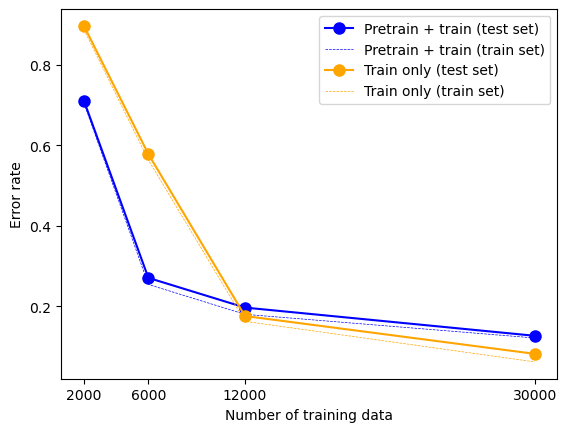

In [ ]:
plot_DNN(
    samples_sizes, 
    acc_1_train_size, 
    acc_2_train_size, 
    acc_1_train=acc_1_train_size_train, 
    acc_2_train=acc_2_train_size_train, 
    y_label='Number of training data', 
    save="mnist_number_of_training_data"
    )

In [ ]:
acc_1_batch_size = []
acc_2_batch_size = []
acc_1_batch_size_train = []
acc_2_batch_size_train = []

n_layers = [784] + [2 * n_main] * n_hidden +  [10]


batch_sizes = [16, 32, 64, 128, 256, 512] # ------------------------------------------
# batch_sizes = [16, 32, 64, 128, 256, 512, 1024, 2048]

for batch_size in batch_sizes:
    print(f"--- {batch_size} samples per batch ---")

    """-------------- Model 1 : pre-train + train -------------------"""
    ce_model1, score_model1, train_score_model1 = DNN_main(
        X_train,
        X_test,
        y_train,
        y_test,
        n_layers=n_layers,
        lr=lr,
        batch_size=batch_size,
        pretrain_iter=pretrain_iter,
        train_iter=train_iter,
        verbose=1,
    )
    acc_1_batch_size.append(score_model1)
    acc_1_batch_size_train.append(train_score_model1)

    """-------------- Model 2 : train only ---------------------------"""
    ce_model2, score_model2, train_score_model2 = DNN_main(
        X_train,
        X_test,
        y_train,
        y_test,
        n_layers=n_layers,
        lr=lr,
        batch_size=batch_size,
        pretrain_iter=False,
        train_iter=train_iter,
        verbose=1,
    )
    acc_2_batch_size.append(score_model2)
    acc_2_batch_size_train.append(train_score_model2)

--- 16 samples per batch ---
pré-entrainement
Pretraining DNN...
Training RBM...


100%|██████████| 20/20 [00:04<00:00,  4.71it/s]


Training RBM...


100%|██████████| 20/20 [00:00<00:00, 27.06it/s]


entrainement
Training DNN...


100%|██████████| 100/100 [00:07<00:00, 13.48it/s]


train
test
accuracy_score (train) 0.9354166666666667
accuracy_score (test) 0.8738
entrainement
Training DNN...


100%|██████████| 100/100 [00:07<00:00, 13.40it/s]


train
test
accuracy_score (train) 0.99975
accuracy_score (test) 0.9118
--- 32 samples per batch ---
pré-entrainement
Pretraining DNN...
Training RBM...


100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


Training RBM...


100%|██████████| 20/20 [00:00<00:00, 38.24it/s]


entrainement
Training DNN...


100%|██████████| 100/100 [00:17<00:00,  5.57it/s]


train
test
accuracy_score (train) 0.9323333333333333
accuracy_score (test) 0.8876
entrainement
Training DNN...


100%|██████████| 100/100 [00:20<00:00,  4.86it/s]


train
test
accuracy_score (train) 0.995
accuracy_score (test) 0.9085
--- 64 samples per batch ---
pré-entrainement
Pretraining DNN...
Training RBM...


100%|██████████| 20/20 [00:08<00:00,  2.48it/s]


Training RBM...


100%|██████████| 20/20 [00:00<00:00, 43.88it/s]


entrainement
Training DNN...


100%|██████████| 100/100 [00:12<00:00,  8.15it/s]


train
test
accuracy_score (train) 0.903
accuracy_score (test) 0.8652
entrainement
Training DNN...


100%|██████████| 100/100 [00:11<00:00,  8.85it/s]


train
test
accuracy_score (train) 0.9788333333333333
accuracy_score (test) 0.9095
--- 128 samples per batch ---
pré-entrainement
Pretraining DNN...
Training RBM...


100%|██████████| 20/20 [00:07<00:00,  2.85it/s]


Training RBM...


100%|██████████| 20/20 [00:00<00:00, 46.28it/s]


entrainement
Training DNN...


100%|██████████| 100/100 [00:08<00:00, 11.37it/s]


train
test
accuracy_score (train) 0.8726666666666667
accuracy_score (test) 0.8453
entrainement
Training DNN...


100%|██████████| 100/100 [00:08<00:00, 11.83it/s]


train
test
accuracy_score (train) 0.9415833333333333
accuracy_score (test) 0.8989
--- 256 samples per batch ---
pré-entrainement
Pretraining DNN...
Training RBM...


100%|██████████| 20/20 [00:07<00:00,  2.70it/s]


Training RBM...


100%|██████████| 20/20 [00:00<00:00, 52.66it/s]


entrainement
Training DNN...


100%|██████████| 100/100 [00:08<00:00, 11.77it/s]


train
test
accuracy_score (train) 0.832
accuracy_score (test) 0.8161
entrainement
Training DNN...


100%|██████████| 100/100 [00:08<00:00, 12.29it/s]


train
test
accuracy_score (train) 0.811
accuracy_score (test) 0.786
--- 512 samples per batch ---
pré-entrainement
Pretraining DNN...
Training RBM...


100%|██████████| 20/20 [00:07<00:00,  2.75it/s]


Training RBM...


100%|██████████| 20/20 [00:00<00:00, 48.10it/s]


entrainement
Training DNN...


100%|██████████| 100/100 [00:08<00:00, 12.17it/s]


train
test
accuracy_score (train) 0.7398333333333333
accuracy_score (test) 0.7294
entrainement
Training DNN...


100%|██████████| 100/100 [00:07<00:00, 12.97it/s]


train
test
accuracy_score (train) 0.3924166666666667
accuracy_score (test) 0.3926


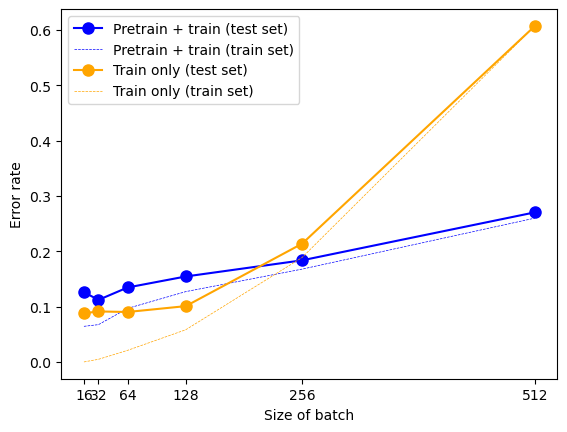

In [ ]:
plot_DNN(
    batch_sizes, 
    acc_1_batch_size, 
    acc_2_batch_size, 
    acc_1_train=acc_1_batch_size_train, 
    acc_2_train=acc_2_batch_size_train, 
    y_label='Size of batch', 
    save="mnist_size_of_batch"
    )

In [ ]:
acc_1_pretrain_iter = []
acc_2_pretrain_iter = []
acc_1_pretrain_iter_train = []
acc_2_pretrain_iter_train = []

n_layers = [784] + [2 * n_main] * n_hidden +  [10]


pretrain_iter_sizes = [10, 20, 50, 100] # ------------------------------------------
# pretrain_iter_sizes = [10, 20, 50, 100, 200, 300]

for pretrain_iter_ in pretrain_iter_sizes:
    print(f"--- {pretrain_iter_} iterations per RBM in pretrain ---")

    """-------------- Model 1 : pre-train + train -------------------"""
    ce_model1, score_model1, train_score_model1 = DNN_main(
        X_train,
        X_test,
        y_train,
        y_test,
        n_layers=n_layers,
        lr=lr,
        batch_size=batch_size,
        pretrain_iter=pretrain_iter_,
        train_iter=train_iter,
        verbose=1,
    )
    acc_1_pretrain_iter.append(score_model1)
    acc_1_pretrain_iter_train.append(train_score_model1)

    """-------------- Model 2 : train only ---------------------------"""
    ce_model2, score_model2, train_score_model2 = DNN_main(
        X_train,
        X_test,
        y_train,
        y_test,
        n_layers=n_layers,
        lr=lr,
        batch_size=batch_size,
        pretrain_iter=False,
        train_iter=train_iter,
        verbose=1,
    )
    acc_2_pretrain_iter.append(score_model2)
    acc_2_pretrain_iter_train.append(train_score_model2)

--- 10 iterations per RBM in pretrain ---
pré-entrainement
Pretraining DNN...
Training RBM...


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


Training RBM...


100%|██████████| 10/10 [00:00<00:00, 51.22it/s]


entrainement
Training DNN...


100%|██████████| 100/100 [00:07<00:00, 12.98it/s]


train
test
accuracy_score (train) 0.6873333333333334
accuracy_score (test) 0.6811
entrainement
Training DNN...


100%|██████████| 100/100 [00:07<00:00, 13.68it/s]


train
test
accuracy_score (train) 0.3535
accuracy_score (test) 0.3418
--- 20 iterations per RBM in pretrain ---
pré-entrainement
Pretraining DNN...
Training RBM...


100%|██████████| 20/20 [00:07<00:00,  2.71it/s]


Training RBM...


100%|██████████| 20/20 [00:00<00:00, 52.12it/s]


entrainement
Training DNN...


100%|██████████| 100/100 [00:09<00:00, 10.26it/s]


train
test
accuracy_score (train) 0.7158333333333333
accuracy_score (test) 0.6958
entrainement
Training DNN...


100%|██████████| 100/100 [00:08<00:00, 12.01it/s]


train
test
accuracy_score (train) 0.376
accuracy_score (test) 0.3629
--- 50 iterations per RBM in pretrain ---
pré-entrainement
Pretraining DNN...
Training RBM...


100%|██████████| 50/50 [00:17<00:00,  2.81it/s]


Training RBM...


100%|██████████| 50/50 [00:00<00:00, 64.39it/s]


entrainement
Training DNN...


100%|██████████| 100/100 [00:07<00:00, 13.08it/s]


train
test
accuracy_score (train) 0.78775
accuracy_score (test) 0.7698
entrainement
Training DNN...


100%|██████████| 100/100 [00:07<00:00, 12.61it/s]


train
test
accuracy_score (train) 0.35075
accuracy_score (test) 0.342
--- 100 iterations per RBM in pretrain ---
pré-entrainement
Pretraining DNN...
Training RBM...


100%|██████████| 100/100 [00:35<00:00,  2.85it/s]


Training RBM...


100%|██████████| 100/100 [00:01<00:00, 64.82it/s]


entrainement
Training DNN...


100%|██████████| 100/100 [00:07<00:00, 12.97it/s]


train
test
accuracy_score (train) 0.796
accuracy_score (test) 0.7851
entrainement
Training DNN...


100%|██████████| 100/100 [00:07<00:00, 13.14it/s]


train
test
accuracy_score (train) 0.3873333333333333
accuracy_score (test) 0.385


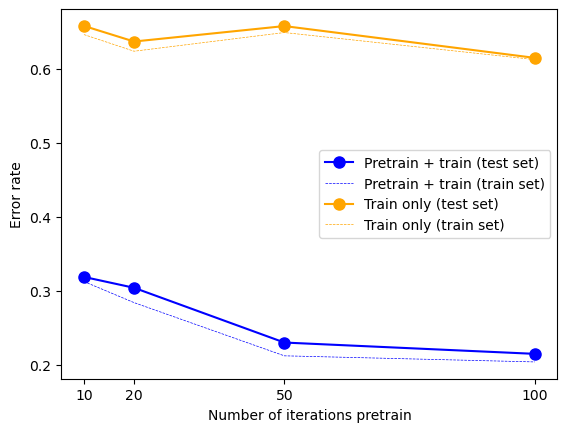

In [ ]:
plot_DNN(
    pretrain_iter_sizes, 
    acc_1_pretrain_iter, 
    acc_2_pretrain_iter, 
    acc_1_train=acc_1_pretrain_iter_train, 
    acc_2_train=acc_2_pretrain_iter_train, 
    y_label='Number of iterations pretrain', 
    save="mnist_number_of_pretrain_iter"
    )

In [ ]:
acc_1_train_iter = []
acc_2_train_iter = []
acc_1_train_iter_train = []
acc_2_train_iter_train = []

n_layers = [784] + [2 * n_main] * n_hidden +  [10]


train_iter_sizes = [20, 50, 100, 200, 300] # ------------------------------------------
# train_iter_sizes = [20, 50, 100, 200, 300, 500]

for train_iter_ in train_iter_sizes:
    print(f"--- {train_iter_} iterations in DNN train ---")

    """-------------- Model 1 : pre-train + train -------------------"""
    ce_model1, score_model1, train_score_model1 = DNN_main(
        X_train,
        X_test,
        y_train,
        y_test,
        n_layers=n_layers,
        lr=lr,
        batch_size=batch_size,
        pretrain_iter=pretrain_iter,
        train_iter=train_iter_,
        verbose=1,
    )
    acc_1_train_iter.append(score_model1)
    acc_1_train_iter_train.append(train_score_model1)

    """-------------- Model 2 : train only ---------------------------"""
    ce_model2, score_model2, train_score_model2 = DNN_main(
        X_train,
        X_test,
        y_train,
        y_test,
        n_layers=n_layers,
        lr=lr,
        batch_size=batch_size,
        pretrain_iter=False,
        train_iter=train_iter_,
        verbose=1,
    )
    acc_2_train_iter.append(score_model2)
    acc_2_train_iter_train.append(train_score_model2)

--- 20 iterations in DNN train ---
pré-entrainement
Pretraining DNN...
Training RBM...


100%|██████████| 20/20 [00:07<00:00,  2.82it/s]


Training RBM...


100%|██████████| 20/20 [00:00<00:00, 55.05it/s]


entrainement
Training DNN...


100%|██████████| 20/20 [00:01<00:00, 13.23it/s]


train
test
accuracy_score (train) 0.5126666666666667
accuracy_score (test) 0.5091
entrainement
Training DNN...


100%|██████████| 20/20 [00:01<00:00, 13.31it/s]


train
test
accuracy_score (train) 0.11258333333333333
accuracy_score (test) 0.1135
--- 50 iterations in DNN train ---
pré-entrainement
Pretraining DNN...
Training RBM...


100%|██████████| 20/20 [00:06<00:00,  2.90it/s]


Training RBM...


100%|██████████| 20/20 [00:00<00:00, 54.53it/s]


entrainement
Training DNN...


100%|██████████| 50/50 [00:03<00:00, 12.62it/s]


train
test
accuracy_score (train) 0.6594166666666667
accuracy_score (test) 0.6497
entrainement
Training DNN...


100%|██████████| 50/50 [00:03<00:00, 13.93it/s]


train
test
accuracy_score (train) 0.11258333333333333
accuracy_score (test) 0.1135
--- 100 iterations in DNN train ---
pré-entrainement
Pretraining DNN...
Training RBM...


100%|██████████| 20/20 [00:06<00:00,  2.87it/s]


Training RBM...


100%|██████████| 20/20 [00:00<00:00, 53.71it/s]


entrainement
Training DNN...


100%|██████████| 100/100 [00:07<00:00, 13.38it/s]


train
test
accuracy_score (train) 0.7460833333333333
accuracy_score (test) 0.7359
entrainement
Training DNN...


100%|██████████| 100/100 [00:07<00:00, 13.77it/s]


train
test
accuracy_score (train) 0.31316666666666665
accuracy_score (test) 0.3007
--- 200 iterations in DNN train ---
pré-entrainement
Pretraining DNN...
Training RBM...


100%|██████████| 20/20 [00:07<00:00,  2.82it/s]


Training RBM...


100%|██████████| 20/20 [00:00<00:00, 58.23it/s]


entrainement
Training DNN...


100%|██████████| 200/200 [00:15<00:00, 13.21it/s]


train
test
accuracy_score (train) 0.8465833333333334
accuracy_score (test) 0.8265
entrainement
Training DNN...


100%|██████████| 200/200 [00:14<00:00, 13.61it/s]


train
test
accuracy_score (train) 0.8089166666666666
accuracy_score (test) 0.7819
--- 300 iterations in DNN train ---
pré-entrainement
Pretraining DNN...
Training RBM...


100%|██████████| 20/20 [00:07<00:00,  2.80it/s]


Training RBM...


100%|██████████| 20/20 [00:00<00:00, 49.57it/s]


entrainement
Training DNN...


100%|██████████| 300/300 [00:22<00:00, 13.56it/s]


train
test
accuracy_score (train) 0.8680833333333333
accuracy_score (test) 0.8483
entrainement
Training DNN...


100%|██████████| 300/300 [00:21<00:00, 14.25it/s]


train
test
accuracy_score (train) 0.9205
accuracy_score (test) 0.8888


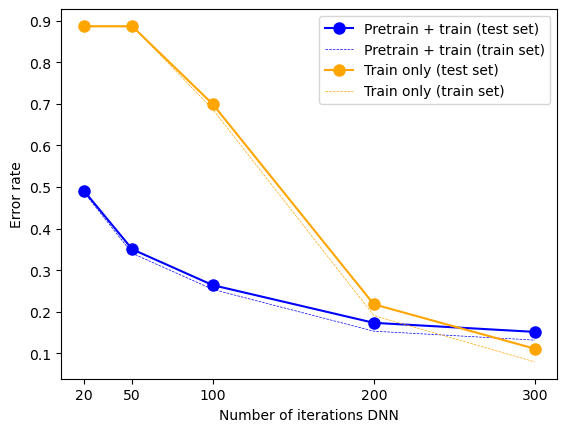

In [ ]:
plot_DNN(
    train_iter_sizes, 
    acc_1_train_iter, 
    acc_2_train_iter, 
    acc_1_train=acc_1_train_iter_train, 
    acc_2_train=acc_2_train_iter_train, 
    y_label='Number of iterations DNN', 
    save="mnist_number_of_train_iter"
    )

In [ ]:
n_main, n_hidden, pretrain_iter, train_iter

(10, 2, 20, 100)

#### Resultat avec les meilleurs paramètres

A CALIBRER APRES

In [ ]:
# """-------------- Model 1 : pre-train + train -------------------"""

# X_train_f, X_test, y_train_f, y_test = lire_mnist(subsample_size=-1)
# n_layers = [784, 300, 300, 10]
# # n_layers = [784, 400, 10]
# pretrain_iter = 100
# train_iter = 200

# ce_model1, score_model1 = DNN_main(
#     X_train_f,
#     X_test,
#     y_train_f,
#     y_test,
#     n_layers=n_layers,
#     lr=lr,
#     batch_size=batch_size,
#     pretrain_iter=pretrain_iter,
#     train_iter=train_iter,
#     verbose=1,
# )

# """-------------- Model 2 : train only ---------------------------"""
# pretrain_iter = False
# n_layers = [784, 100, 10]
# ce_model2, score_model2 = DNN_main(
#     X_train_f,
#     X_test,
#     y_train_f,
#     y_test,
#     n_layers=n_layers,
#     lr=lr,
#     batch_size=batch_size,
#     pretrain_iter=pretrain_iter,
#     train_iter=train_iter,
#     verbose=1,
# )


# print("----------  Resultat model 1 : pré-entraînément + entraînément  --------- ")
# print("            cross_entropie : ", ce_model1)
# print("            Accuracy : ", score_model1)
# print("       ")
# print("----------  Resultat model 2 : uniquement entrainé  --------- ")
# print("            cross_entropie : ", ce_model2)
# print("            Accuracy : ", score_model2)

# VAE

In [ ]:
# X_train, X_test, y_train, y_test = lire_mnist(subsample_size=-1)

In [ ]:
# class VAE(nn.Module):
#     def __init__(self, input_dim, hidden_dim, latent_dim):
#         super(VAE, self).__init__()

#         self.input_dim = input_dim
#         self.hidden_dim = hidden_dim
#         self.latent_dim = latent_dim

#         self.fc1 = nn.Linear(input_dim, hidden_dim)
#         self.fc21 = nn.Linear(hidden_dim, latent_dim)
#         self.fc22 = nn.Linear(hidden_dim, latent_dim)
#         self.fc3 = nn.Linear(latent_dim, hidden_dim)
#         self.fc4 = nn.Linear(hidden_dim, input_dim)

#     def encode(self, x):
#         h1 = F.relu(self.fc1(x))
#         return self.fc21(h1), self.fc22(h1)

#     def reparameterize(self, mu, logvar):
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         return eps.mul(std).add_(mu)

#     def decode(self, z):
#         h3 = F.relu(self.fc3(z))
#         return torch.sigmoid(self.fc4(h3))

#     def forward(self, x):
#         mu, logvar = self.encode(x.view(-1, self.input_dim))
#         z = self.reparameterize(mu, logvar)
#         return self.decode(z), mu, logvar

In [ ]:
# def loss_function(recon_x, x, mu, logvar):
#     BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")

#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

#     return BCE + KLD

In [ ]:
# def train(model, device, train_loader, optimizer, epoch, verbose=1):
#     model.train()
#     train_loss = 0
#     for batch_idx, (data, _) in enumerate(train_loader):
#         data = data.to(device)
#         optimizer.zero_grad()
#         recon_batch, mu, logvar = model(data)
#         loss = loss_function(recon_batch, data, mu, logvar)
#         loss.backward()
#         train_loss += loss.item()
#         optimizer.step()
#         if batch_idx % 100 == 0 and verbose >= 2:
#             print(
#                 "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
#                     epoch,
#                     batch_idx * len(data),
#                     len(train_loader.dataset),
#                     100.0 * batch_idx / len(train_loader),
#                     loss.item() / len(data),
#                 )
#             )
#     if verbose >= 1:
#         print(
#             "====> Epoch: {} Average loss: {:.4f}".format(
#                 epoch, train_loss / len(train_loader.dataset)
#             )
#         )


# def test(model, device, test_loader, verbose=1):
#     model.eval()
#     test_loss = 0
#     with torch.no_grad():
#         for i, (data, _) in enumerate(test_loader):
#             data = data.to(device)
#             recon_batch, mu, logvar = model(data)
#             test_loss += loss_function(recon_batch, data, mu, logvar).item()
#             if i == 0:
#                 n = min(data.size(0), 8)
#                 comparison = torch.cat(
#                     [data[:n], recon_batch.view(batch_size, 1, 28, 28)[:n]]
#                 )
#                 save_image(
#                     comparison.cpu(),
#                     "reconstruction.png",
#                     nrow=n,
#                 )

#     test_loss /= len(test_loader.dataset)
#     if verbose >= 1:
#         print("====> Test set loss: {:.4f}".format(test_loss))


# def VAE_main(train_loader, test_loader, batch_size, epochs, lr):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     kwargs = {"num_workers": 1, "pin_memory": True} if torch.cuda.is_available() else {}

#     model = VAE(784, 400, 20).to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#     for epoch in tqdm(range(1, epochs + 1)):
#         train(model, device, train_loader, optimizer, epoch)
#         test(model, device, test_loader)
#         with torch.no_grad():
#             sample = torch.randn(64, 20).to(device)
#             sample = model.decode(sample).cpu()
#             save_image(
#                 sample.view(64, 1, 28, 28),
#                 "sample_" + str(epoch) + ".png",
#             )

In [ ]:
# mnist_train = datasets.MNIST(
#     "data/", train=True, download=True, transform=transforms.ToTensor()
# )
# mnist_test = datasets.MNIST(
#     "data/", train=False, download=True, transform=transforms.ToTensor()
# )
# train_loader = torch.utils.data.DataLoader(
#     mnist_train,
#     batch_size=batch_size,
#     shuffle=True,
# )
# test_loader = torch.utils.data.DataLoader(
#     mnist_test,
#     batch_size=batch_size,
#     shuffle=True,
# )

# VAE_main(train_loader, test_loader, batch_size=128, epochs=10, lr=1e-3)